[`DetectionValidator`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/val.py)

In [ ]:
%matplotlib inline
__import__("os").environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [ ]:
import os
import copy
import matplotlib.pyplot as plt

import torch
import random
import numpy as np

seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
import sys
sys.path.append('../../..')

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.utils.check import check_imgsz
from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.parameter_parser import parser
from computer_vision.yolov11.data.dataset import YOLODataset
from computer_vision.yolov11.modules.validator import DetectionValidator

In [ ]:
data_dirpath=r'D:/data/ultralytics/coco128'
result_dirpath='D:/results/yolov11/training'

argument=f'''--root {data_dirpath} --train-image-dirname images/train2017 --train-label-dirname labels/train2017
--val-image-dirname images/train2017 --val-label-dirname labels/train2017
--data-cfg ../coco128.yaml --hyperparam ../default.yaml --model-cfg ../yolo11.yaml 
--batch-size 2 --output-dirpath {result_dirpath} --checkpoint-dirpath {result_dirpath}/checkpoints 
--save-period 1 '''
args=parser.parse_args(argument.split())

if not os.path.isdir(args.checkpoint_dirpath): os.makedirs(args.checkpoint_dirpath)

[`DetMetrics`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/metrics.py#L1032)

In [ ]:
from __future__ import annotations

import os
import yaml
import copy
from pathlib import Path
from typing import Any
from argparse import Namespace

import torch
import numpy as np
from computer_vision.yolov11.utils.metrics import Metric
from computer_vision.yolov11.utils import ops

[`DetectionValidator`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/val.py#L16)

In [ ]:
val_dataset=YOLODataset(img_path=(Path(args.root)/args.val_image_dirname),
                        label_path=(Path(args.root)/args.val_label_dirname),
                        data=args.data_cfg, hyp=args.hyperparam, imgsz=args.imgsz, cache=True, augment=False, rect=False, 
                        batch_size=args.batch_size, stride=32, pad=0.5,  single_cls=False, classes=None, fraction=1., channels=3)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, sampler=None, batch_sampler=None, 
                                       num_workers=0, collate_fn=YOLODataset.collate_fn, pin_memory=False, drop_last=False, 
                                       timeout=0, worker_init_fn=None, prefetch_factor=None, persistent_workers=False)
validator=DetectionValidator(hyperparam=Path(args.hyperparam), data_cfg=val_dataset.data, dataloader=val_loader, 
                 save_dir=Path(args.output_dirpath), args=args)

In [ ]:
model_dirpath='D:/results/yolov11/checkpoints'
# to load ultralytics models (models downloaded previously by ultralytics) we need to use ultralytics library, as a work around,
# we resave it using torch to remove ultralytics dependency
# checkpoint=torch.load(os.path.join(model_dirpath, 'yolo11n.pt'), map_location=torch.device('cpu'), weights_only=False)

model=DetectionModel(cfg='../yolo11.yaml', ch=3)
checkpoint=torch.load(os.path.join(model_dirpath, 'predictor_yolo11n_torch.pt'), map_location=torch.device('cpu'), weights_only=True) # may have model. as added prefix
try:
    model.load_state_dict(checkpoint['model'])
except RuntimeError as err:
    state_dict=copy.deepcopy(model.state_dict())
    for name, params in checkpoint['model'].items():
        name=name[len('model.'):] # each parameter name is model.model.xxx so we need to remove 1 model.
        
        if name not in state_dict or params.shape!=state_dict[name].shape:
            print(name, name in state_dict, params.shape!=state_dict[name].shape if name in state_dict else None)
        else: state_dict[name]=params
    model.load_state_dict(state_dict)
    print('Load model with modify name')

In [ ]:
from computer_vision.yolov11.utils.plotting import plot_labels, plot_predictions

In [ ]:
trainer=None

# def __call__
validator.training=trainer is not None
augment=validator.args.augment and (not validator.training)
print('augment ', augment)
if validator.training:
    validator.device=trainer.device
    validator.data=trainer.data
    model=trainer.ema.ema or trainer.model
    model=model.float()
    validator.loss=torch.zeros_like(trainer.loss_items, device=trainer.device)
    validator.args.plots&=trainer.stopper.possible_stop or (trainer.epoch==trainer.epochs-1)
    model.eval()
else:
    assert all(x is not None for x in [model, validator.dataloader])
    validator.device=next(model.parameters()).device
    imgsz=check_imgsz(validator.args.imgsz, stride=model.stride)
    print('imgsz ', imgsz)
    if not getattr(model, 'dynamic', False): validator.args.batch=1
    if validator.device.type in {'cpu', 'mps'}: validator.args.workers=0 # faster since time dominated by inference, not dataloading
    # what is imx?
    if not getattr(model, 'dynamic', False): validator.args.rect=False
    validator.stride=model.stride # used in get_dataloader() for padding
    model.eval()
validator.init_metrics(model)
validator.jdict=[] # empty before each val

for batch_i, batch in enumerate(validator.dataloader):
    print(batch_i, end=',')
    validator.batch_i=batch_i
    
    # Preprocessing
    batch=validator.preprocess(batch)

    # Inference
    with torch.no_grad(): preds=model(batch['img'])

    # Loss
    if validator.training:
        with torch.no_grad(): validator.loss+=model.loss(batch, preds)[1]
            
    # Postprocess  
    preds=validator.postprocess(preds) # with bounding boxes in xyxy in pixel units

    validator.update_metrics(preds, batch)

    if validator.args.plots and batch_i<3:
        fname='-'.join(Path(l).stem for l in batch['im_file'])
        plot_labels(copy.deepcopy(batch), fname=validator.save_dir/'{}-label.jpg'.format(fname),
                    xywh=True)
        plot_predictions(images=batch['img'].clone(), prediction=copy.deepcopy(preds), 
                         fname=validator.save_dir/'{}-pred.jpg'.format(fname))

[`DetectionValidator.get_stats`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/val.py#L229)
[`DetMetrics.process`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/metrics.py#L1087)

In [ ]:
# def get_stats(self)->dict[str, Any]
# self.metrics.process(save_dir)
print('validator.save_dir ', validator.save_dir, ' validator.args.plots ', validator.args.plots)
# DetMetrics.process
save_dir=validator.save_dir
plot=validator.args.plots
metrics=validator.metrics

from computer_vision.yolov11.utils.metrics import ap_per_class

# stats stores 
# - `tp` as list[np.ndarray], each np.ndarray of size Dx10 where D is the number of detections (which varies across images)
# - `conf` as a list[np.ndarray], each np.ndarray of size (D,) where D is the number of detections (which varies across images)
# - `pred_cls` a list[np.ndarray],  each np.ndarray of size (D,) where D is the number of detections (which varies across images)
# - `target_cls` a list[np.ndarray], each np.ndarray of size (L,) where L is the number of target classes matching detection (which varies across images)
# - `target_img` a list[np.ndarray], each np.ndarray of size (U,) where U<L is the number of unique target classes matching detection (which varies across images)
stats={k:np.concatenate(v, axis=0) for k, v in metrics.stats.items()}
print('stats ', {k:s.shape for k,s in stats.items()})
#if not stats: return stats
results=ap_per_class(tp=stats['tp'], conf=stats['conf'],
                 pred_cls=stats['pred_cls'], target_cls=stats['target_cls'], plot=plot,
                save_dir=save_dir, names=metrics.names)[2:]


In [85]:
prec_values.shape

(71, 1000)

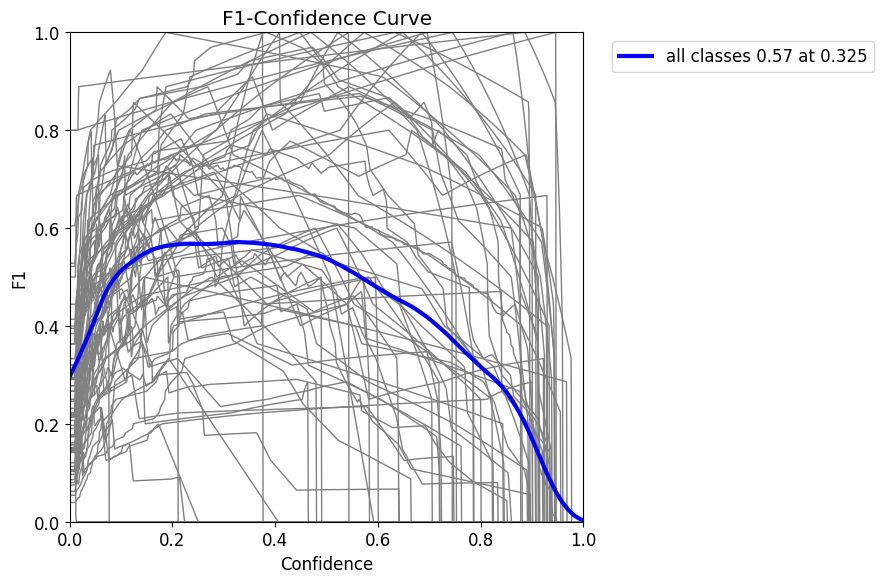

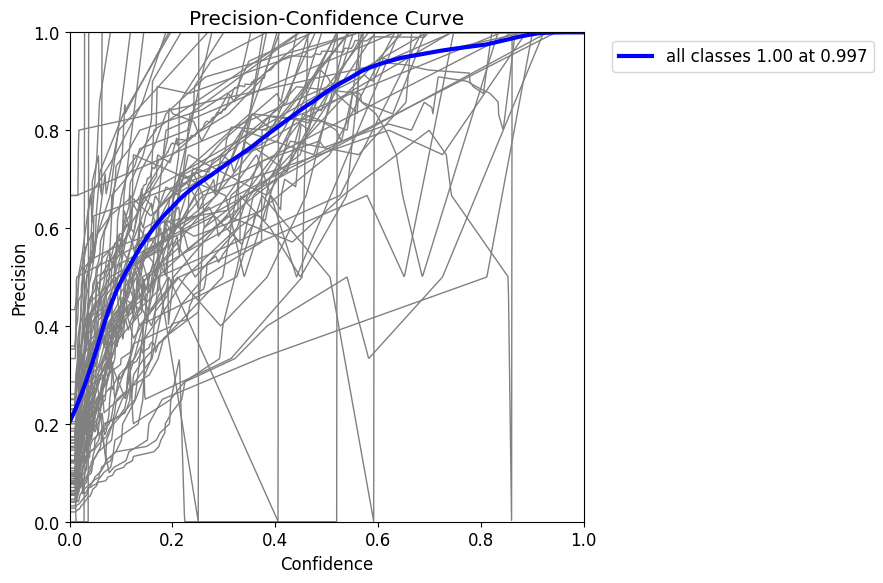

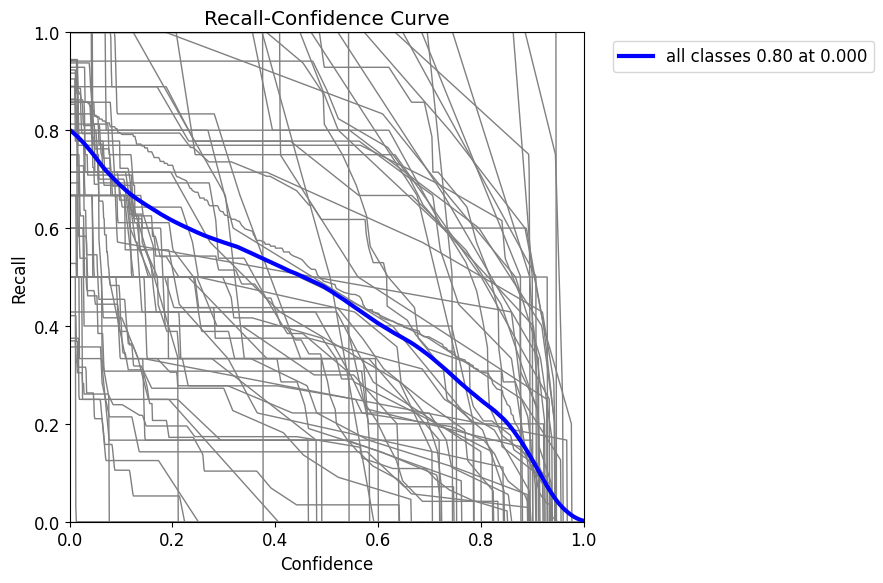

p (71,), r (71,), f1 (71,)
tp (71,), fp (71,)


In [82]:
nt.shape

(71,)

000000000030


In [40]:
validator.class_map[int]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]

In [23]:
validator.save_dir




WindowsPath('D:/results/yolov11/training')

In [125]:
pred_classes.shape, iou.shape, true_classes.shape

(torch.Size([26]), (2, 26), torch.Size([2]))

In [103]:

def match_predictions(self, pred_class:torch.Tensor, true_classes:torch.Tensor, iou:torch.Tensor)->torch.Tensor:
    """
    Match predictions to ground truth objects using IoU
    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape (D,)
        true_classes (torch.Tensor): Target class indices of shape (L,)
        iou (torch.Tensor): An LxD tensor containing the pairwise IoU values for predictions and ground truth
    Returns:
        (torch.Tensor): Correct tensir of shape (D,10) for 10 IoU thresholds
    """
    # Dx10 matrix where D is detections and 10 is IoU threshold
    correct=np.zeros((pred_classes.shape[0], self.iouv.shape[0])).astype(bool)
    # LxD matrix where L is labels (rows) and D is detections (columns)
    correct_class=true_classes[:,None]==pred_classes # (L->Lx1 , D) -> LxD
    iou=iou*correct_class.to(dtype=iou.dtype) # zero out wrong classes
    iou=iou.cpu().numpy()
    for i, threshold in enumerate(self.iouv.cpu().tolist()):
        # LxD IoU > threshold with classes matched
        # tuple of 2 array for 2D dimension: one for L and the others for D
        matches=np.nonzero(iou>=threshold) 
        # Nx2 where N is the number of matches and 2 for L index and D index respectively
        matches=np.array(matches).T 
        if matches.shape[0]:
            if matches.shape[0]>1:
                # iou[matches[:,0], matches[:,1]] gets IoUs that yeild match. This will return IoU for each match
                # iou[matches[:,0], matches[:,1]].argsort() gets match indices that sort iou from small IoU to large IoU
                # iou[matches[:,0], matches[:,1]].argsort()[::-1] gets match indices that sort from large to small
                matches=matches[iou[matches[:,0], matches[:,1]].argsort()[::-1]]
                # get matches that associates with unique detections
                matches=matches[np.unique(matches[:,1], return_index=True)[1]]
                # get matches that associates with unique labels
                matches=matches[np.unique(matches[:,0], return_index=True)[1]]
            # Put True in (detection-index, threshold-index) in correct
            correct[matches[:,1].astype(int),i]=True
    return torch.tensor(correct, dtype=torch.bool, device=pred_classes.device)

pred_classes  torch.Size([26])  true_classes  torch.Size([2])  iou  torch.Size([2, 26])


0 0.5
		 2


In [123]:
correct.shape

(26, 10)

In [122]:
matches[:,1]

array([1, 0])

In [121]:
matches.shape, matches

((2, 2),
 array([[0, 1],
        [1, 0]]))

In [117]:
matches[:,0], np.unique(matches[:,0], return_index=True)[1]

(array([0, 1, 0]), array([0, 1]))